## Loading data from CSV files:

In [1]:
import pandas as pd
from pathlib import Path

data = Path("../pet_finder") / "data"

print('Train')
train = pd.read_csv(data / "train" / "train.csv")
print(train.shape)

print('Test')
test = pd.read_csv(data / "test" / "test.csv")
print(test.shape)

print('Breeds')
breeds = pd.read_csv(data / "breed_labels.csv")
print(breeds.shape)

print('Colors')
colors = pd.read_csv(data / "color_labels.csv")
print(colors.shape)

print('States')
states = pd.read_csv(data / "state_labels.csv")
print(states.shape)

Train
(14993, 24)
Test
(3972, 23)
Breeds
(307, 3)
Colors
(7, 2)
States
(15, 2)


In [2]:
target = train['AdoptionSpeed']
train.set_index('PetID', inplace=True)
test.set_index('PetID', inplace=True)

train.drop(['AdoptionSpeed', 'Name'], 
           axis=1,
           inplace=True)
test.drop(['Name'],
          axis=1,
          inplace=True)

## Features extraction  from pet description:

## Statistics on description's sentiment analysis:

Natural Language processing (NLP) uses machine learning to reveal the structure and meaning of text. With NLP, 
we can extract information about people, places, and events, and better understand social media sentiment and 
customer conversations. 

For our project, We have for each pet profile's description an analysis on  sentiment and key entities 
provided by Google's Natural Language API. There are some descriptions that the API could not analyze. As 
such, there are fewer sentiment files than there are rows in the dataset.

Google Natural Language API reference: https://cloud.google.com/natural-language/docs/basics


In [3]:
import json
import numpy as np
import scipy.stats as sc
from tqdm.notebook import tqdm

def append_statistics(string):
    statistics = pd.DataFrame(index=(globals()[string]).index, 
                              columns=["documentSentiment mag", 
                                       "documentSentiment score",
                                       "mag mean",
                                       "mag std",
                                       "mag skew",
                                       "mag kurtosis",
                                       "mag sum",
                                       "score mean",
                                       "score std",
                                       "score skew",
                                       "score kurtosis",
                                       "score sum",
                                       "score size"],
                             data=-1)
    for pet in tqdm((globals()[string]).index):
        try: 
            with open(data / (string + "_sentiment") / (pet + '.json'), 'r') as f:
                sentiment = json.load(f)
            score = np.array([])
            mag = np.array([])
            for i in sentiment['sentences']: 
                score = np.append(score, i['sentiment']['score'])  # saving each sentiment score
                mag = np.append(mag, i['sentiment']['magnitude'])  # saving each sentiment magnitude
            statistics.loc[pet, statistics.columns[0]] = sentiment['documentSentiment']['magnitude']
            statistics.loc[pet, statistics.columns[1]] = sentiment['documentSentiment']['score']
            for statistic in statistics.columns[2:]:
                strings = statistic.split(" ")
                # applying statistics on sentiments scores and magnitudes
                try :
                    statistics.loc[pet, statistic] = getattr(np, strings[1])(locals()[strings[0]])
                except AttributeError:
                    statistics.loc[pet, statistic] = getattr(sc, strings[1])(locals()[strings[0]])
        except FileNotFoundError:
            pass
    return globals()[string].join(statistics)

In [4]:
train = append_statistics("train")
test = append_statistics("test")

## term frequency-inverse document frequency:
term frequency-inverse document frequency (tf-idf) is a numerical statistic that reflect how important a word 
to a document (for our project document is pet profile's description) in a corpus (for our project corpus is 
all pet profile's descriptions).

The tf-idf value increases proportionally to the number of times a word appears in the document and is offset 
by the number of documents in the corpus that contain the word.

Hence, tf-idf serves us in determining keywords in each pet profile's description and convert descriptions 
into vectors and each word has its own vector, but tf-idf do not convert directly descriptions into useful 
features and dimension reduction is necessary to remove less-informative "noise" features and for more 
efficient storage and computation.

As tf-idf convert descriptions onto a sparse matrix TruncatedSVD is more appropriate PCA to be used in 
dimension reducing in our case.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

train_description = train.Description.fillna("none").values
test_description = test.Description.fillna("none").values

tfv = TfidfVectorizer(min_df=3,  # ignore words that have a df strictly lower than 3
                      max_features=10000,  # vocabulary size limited to 10000
                      strip_accents='unicode',
                      analyzer='word',  # bow
                      token_pattern=r'\w{1,}',
                      ngram_range=(1, 3), 
                      use_idf=1,
                      smooth_idf=1,
                      sublinear_tf=1,
                      stop_words = 'english')  # filter noisy words, i.e words that are used
                                               # to formulate sentences but do not add any semantic
                                               # meaning to the description.
# Fit TFIDF
tfv.fit(list(train_description))

# Vectorize descriptions
train_matrix =  tfv.transform(train_description)
test_matrix = tfv.transform(test_description)

svd = TruncatedSVD(n_components=80)

# Fit TruncatedSVD
svd.fit(train_matrix)
ratio = svd.explained_variance_ratio_.sum()
print(f"Sum of explained variance ratio of svd decomposition is: {ratio: 0.2}")

# Reducing dimension of tf-idf matrix with svd transformation
train_svd = svd.transform(train_matrix)
train_svd = pd.DataFrame(data=train_svd,
                         columns=['svd_{}'.format(i) for i in range(80)],
                         index=train.index)
test_svd = svd.transform(test_matrix)
test_svd = pd.DataFrame(data=test_svd,
                        columns=['svd_{}'.format(i) for i in range(80)],
                        index=test.index)

# Join tf-idf  to dataframes
train = train.join(train_svd)
test = test.join(test_svd)

train.drop(['Description'], axis=1, inplace=True)
test.drop(['Description'], axis=1, inplace=True)

Sum of explained variance ratio of svd decomposition is:  0.19


## Feature extraction from rescuer:

In [6]:
def compute_statistics(data, columns, statistics):
    df = data.groupby(['RescuerID'])[columns] \
             .agg(statistics).reset_index()
    df.columns = ['RescuerID'] + [statistic + '_' + column for column in columns for statistic in statistics]
    return df

In [7]:
all_data = pd.concat([train, test], ignore_index=True)
df = compute_statistics(data=all_data,
                        columns=['Age','Fee','PhotoAmt','VideoAmt','Quantity'],
                        statistics=['min','max','mean','sum'])
train = train.merge(df, on=['RescuerID'], how='left')
test = test.merge(df, on=['RescuerID'], how='left')

In [8]:
df = compute_statistics(data=all_data[all_data['MaturitySize'] > 0],
                        columns=['MaturitySize'],
                        statistics=['min','max','mean','sum'])
train = train.merge(df, on=['RescuerID'], how='left')
test = test.merge(df, on=['RescuerID'], how='left')

In [9]:
df = compute_statistics(data=all_data[all_data['Health'] > 0],
                        columns=['Health'],
                        statistics=['min','max','mean','sum'])
train = train.merge(df, on=['RescuerID'], how='left')
test = test.merge(df, on=['RescuerID'], how='left')

In [10]:
train.drop(['RescuerID'], 
           axis=1,
           inplace=True)
test.drop(['RescuerID'],
          axis=1,
          inplace=True)

## Model - Gradient boosting:
Gradient boosting is a machine learning technique for regression and classification problems, which produces a 
prediction model in the form of an ensemble of weak prediction models, typically decision trees.

## Why use regression as objective function instead of classification:
As evaluation criteria (quadratic kappa) calculate the amount of similarity between predictions and actuals, 
hence  wrong classifications do not affect overall score in the same way. For example if the adoption speed 
for a pet is 4 and its better to predict 3 than 2, 1 or 0.
Chossing regresion as objective function allows the model to avoid prediction with high error.

## Rounding:
As the output of regression is a real number, we need to round it into [0, 1, 2, 3].
A class to optimize rounding on the regression output is provided in python file.

In [11]:
# gradient boosting parameters
params = {'application': 'regression',  # L2 los
          'boosting': 'gbdt',  # traditional Gradiant Boosting Decision Tree
          'metric': 'rmse',  # root square loss
          'min_split_gain': 0.01,  # the minimal gain to perform split
          'min_child_samples': 150,  # minimal number of data in one leaf. 
                                     # used to deal with over-fitting
          'min_child_weight': 0.1,  # minimal sum hessian in one leaf
          'verbosity': -1,
          'data_random_seed': 3,
          'early_stop': 100,
          'verbose_eval': 100,
          'num_rounds': 10000,  # number of boosting iterations
          'max_depth' : 9,  # limit the max depth for tree model.
          'feature_fraction' : 0.4,  # GB will randomly select part of features on
                                     # each iteration (tree)
          'learning_rate': 0.01,  # shrinkage rate
          'bagging_fraction' : 0.8,  # like feature_fraction, but this will randomly select
                                     # part of data without resampling
          'num_leaves' : 80}  # max number of leaves in one tree


In [12]:
#!pip3 install lightgbm
import lightgbm as lgb
from OptimizedRounder import OptimizedRounder
from  sklearn.metrics import cohen_kappa_score, mean_squared_error
from collections import Counter

def runLGB(train_X, train_y, test_X, 
           test_y, test_X2, params,
           save_model=False, file_suffix=None):
    print('Prep LGB')
    d_train = lgb.Dataset(train_X,
                          label=train_y)
    d_valid = lgb.Dataset(test_X,
                          label=test_y)
    watchlist = [d_train, d_valid]
    print('Train LGB')
    num_rounds = params.pop('num_rounds')
    verbose_eval = params.pop('verbose_eval')
    early_stop = None
    if params.get('early_stop'):
        early_stop = params.pop('early_stop')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)
    if save_model:
        model.save_model(f"lgb_regressor_{file_suffix}.txt",
                         num_iteration=model.best_iteration)
    print('Predict 1/2')
    pred_test_y_k = model.predict(test_X,
                                  num_iteration=model.best_iteration)
    optR = OptimizedRounder()
    optR.fit(pred_test_y_k, test_y)
    coefficients = optR.coefficients
    pred_test_y = optR.predict(pred_test_y_k, coefficients)
    print("Valid Counts = ", Counter(test_y))
    print("Predicted Counts = ", Counter(pred_test_y))
    print("Coefficients = ", coefficients)
    qwk = cohen_kappa_score(test_y, pred_test_y, weights='quadratic')
    print("QWK = ", qwk)
    print('Predict 2/2')
    pred_test_y2 = model.predict(test_X2,
                                 num_iteration=model.best_iteration)
    return pred_test_y_k.reshape(-1, 1), pred_test_y2.reshape(-1, 1), model.feature_importance(), coefficients, qwk


In [13]:
from sklearn.model_selection import StratifiedKFold
from math import sqrt

rmse = lambda actual, predicted: sqrt(mean_squared_error(actual, predicted))

def run_cv_model(train, test, target,
                 model_fn, params={}, eval_fn=rmse,
                 label='model', save_model=True):
    kf = StratifiedKFold(n_splits=5, random_state=69, shuffle=True)
    fold_splits = kf.split(train, target)
    cv_scores = []
    qwk_scores = []
    pred_full_test = 0
    pred_train = np.zeros((train.shape[0], 5))
    all_coefficients = np.zeros((5, 4))
    feature_importance_df = pd.DataFrame()
    i = 1
    for dev_index, val_index in fold_splits:
        print('Started ' + label + ' fold ' + str(i) + '/5')
        if isinstance(train, pd.DataFrame):
            dev_X, val_X = train.iloc[dev_index], train.iloc[val_index]
            dev_y, val_y = target[dev_index], target[val_index]
        else:
            dev_X, val_X = train[dev_index], train[val_index]
            dev_y, val_y = target[dev_index], target[val_index]
        params2 = params.copy()
        pred_val_y, pred_test_y, importances, coefficients, qwk = model_fn(train_X=dev_X, 
                                                                           train_y=dev_y,
                                                                           test_X=val_X,
                                                                           test_y=val_y,
                                                                           test_X2=test,
                                                                           params=params2,
                                                                           save_model=save_model,
                                                                           file_suffix=i)
        pred_full_test = pred_full_test + pred_test_y
        pred_train[val_index] = pred_val_y
        all_coefficients[i-1, :] = coefficients
        if eval_fn is not None:
            cv_score = eval_fn(val_y, pred_val_y)
            cv_scores.append(cv_score)
            qwk_scores.append(qwk)
            print(label + ' cv score {}: RMSE {} QWK {}'.format(i, cv_score, qwk))
        fold_importance_df = pd.DataFrame()
        fold_importance_df['feature'] = train.columns.values
        fold_importance_df['importance'] = importances
        fold_importance_df['fold'] = i
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)        
        i += 1
    print('{} cv RMSE scores : {}'.format(label, cv_scores))
    print('{} cv mean RMSE score : {}'.format(label, np.mean(cv_scores)))
    print('{} cv std RMSE score : {}'.format(label, np.std(cv_scores)))
    print('{} cv QWK scores : {}'.format(label, qwk_scores))
    print('{} cv mean QWK score : {}'.format(label, np.mean(qwk_scores)))
    print('{} cv std QWK score : {}'.format(label, np.std(qwk_scores)))
    pred_full_test = pred_full_test / 5.0
    results = {'label': label,
               'train': pred_train, 'test': pred_full_test,
                'cv': cv_scores, 'qwk': qwk_scores,
               'importance': feature_importance_df,
               'coefficients': all_coefficients}
    return results

In [14]:
def grid_scearch_cv(train, test, target, runLGB, params, grid_param) :
    qwk_score = 0
    for i in product(*grid_param.values()) :
        k = 0
        for j in grid_param.keys() :
            print(j, i[k])
            params[j] = i[k]
            k += 1
        result = run_cv_model(train=train,
                              test=test,
                              target=target,
                              model_fn=runLGB, 
                              params=params,
                              label='lgb')
        if np.mean(result['qwk']) > qwk_score :
            best_param = i
            qwk_score = np.mean(result['qwk'])
    k = 0
    for j in grid_param.keys() :
        print(j, best_param[k], qwk_score)
        k += 1


In [15]:
## running cross validation for lgbm model
## number folds = 5

results = run_cv_model(train=train, 
                       test=test,
                       target=target,
                       model_fn=runLGB,
                       params=params,
                       label='lgb',
                       save_model=True)

Started lgb fold 1/5
Prep LGB
Train LGB
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.06021	valid_1's rmse: 1.09628
[200]	training's rmse: 0.999467	valid_1's rmse: 1.06621
[300]	training's rmse: 0.958146	valid_1's rmse: 1.05203
[400]	training's rmse: 0.924362	valid_1's rmse: 1.04275
[500]	training's rmse: 0.89707	valid_1's rmse: 1.03607
[600]	training's rmse: 0.872327	valid_1's rmse: 1.03174
[700]	training's rmse: 0.849812	valid_1's rmse: 1.02796
[800]	training's rmse: 0.829753	valid_1's rmse: 1.02543
[900]	training's rmse: 0.81223	valid_1's rmse: 1.02432
[1000]	training's rmse: 0.794931	valid_1's rmse: 1.02279
[1100]	training's rmse: 0.778642	valid_1's rmse: 1.02112
[1200]	training's rmse: 0.764318	valid_1's rmse: 1.01984
[1300]	training's rmse: 0.749896	valid_1's rmse: 1.01881
[1400]	training's rmse: 0.736641	valid_1's rmse: 1.01783
[1500]	training's rmse: 0.722993	valid_1's rmse: 1.01694
[1600]	training's rmse: 0.71027	valid_1's rmse: 1.0162


Predict 1/2
Valid Counts =  Counter({4: 839, 2: 807, 3: 652, 1: 618, 0: 82})
Predicted Counts =  Counter({2.0: 1255, 4.0: 683, 1.0: 531, 3.0: 529})
Coefficients =  [0.28548533 1.97697461 2.63783678 2.95524785]
QWK =  0.46438887505907467
Predict 2/2
lgb cv score 5: RMSE 1.0319582187924095 QWK 0.46438887505907467
lgb cv RMSE scores : [1.0123718652343594, 1.0318308241464285, 1.0223127166140924, 1.010559382698007, 1.0319582187924095]
lgb cv mean RMSE score : 1.0218066014970595
lgb cv std RMSE score : 0.009157627476672398
lgb cv QWK scores : [0.46411998817761446, 0.4687551641780524, 0.4754874337576488, 0.4878848452647392, 0.46438887505907467]
lgb cv mean QWK score : 0.4721272612874259
lgb cv std QWK score : 0.008887770190784803


## Feature importance:

Text(0.5, 0, 'Relative Importance')

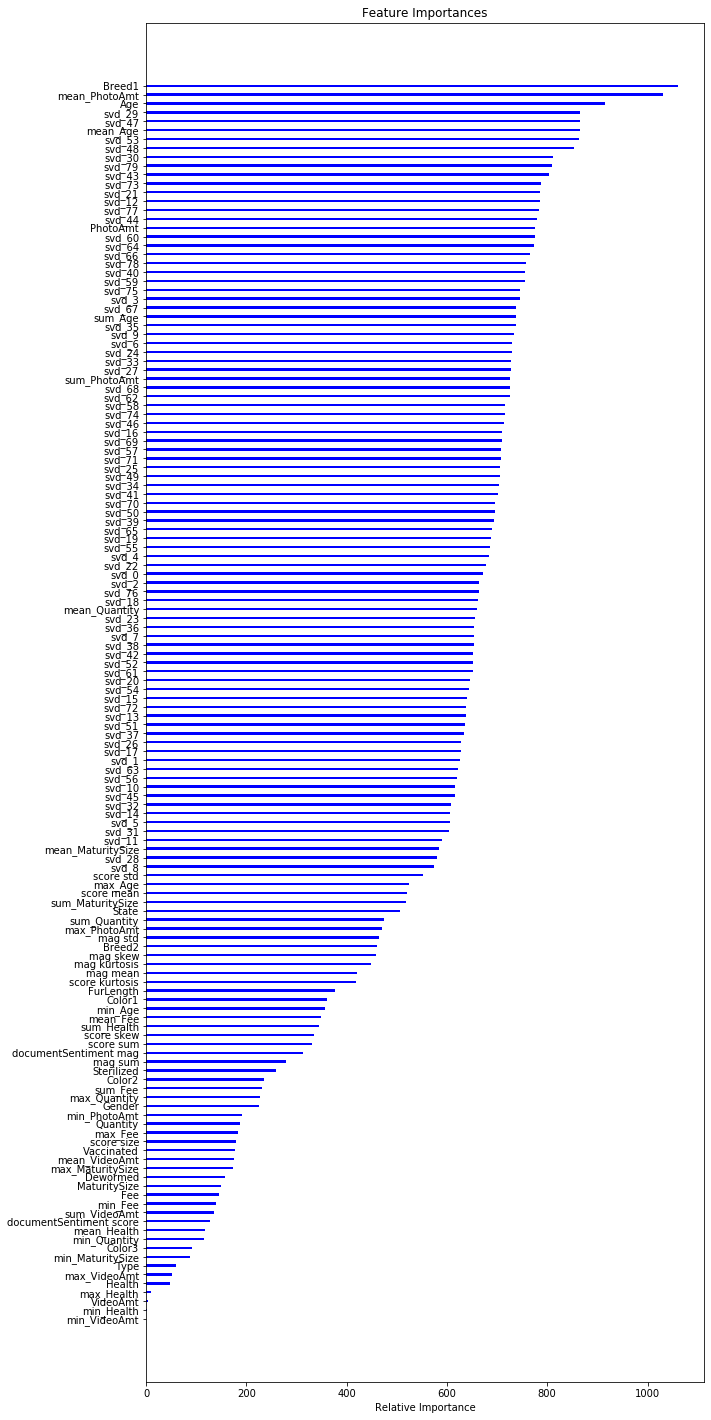

In [16]:
import matplotlib.pyplot as plt

imports = results['importance'].groupby('feature')['feature', 'importance'].mean().reset_index()
imports.sort_values('importance',
                    ascending=True,
                    inplace=True)

# plot of features importances
plt.figure(figsize=(10, 25))
plt.title('Feature Importances')
plt.barh(np.arange(1, 3 * len(imports), 3),
         imports.importance,
         color='b',
         align='center')
plt.yticks(np.arange(1, 3 * len(imports), 3),
           imports.feature)
plt.xlabel('Relative Importance')

## Confusion matrix:

In [17]:
from sklearn.metrics import confusion_matrix as sk_cmatrix

optR = OptimizedRounder()
coefficients = np.mean(results['coefficients'], axis=0)
print(f"coefficients: {coefficients}\n")

train_predictions = [r[0] for r in results['train']]
train_predictions = optR.predict(train_predictions, coefficients).astype(int)

print("Confusion matrix: ")
pd.DataFrame(sk_cmatrix(target, 
                        train_predictions), 
             index=["Label " + str(i) for i in range(5)],
             columns=["Predicted label " + str(i) for i in range(5)])

coefficients: [0.3886723  1.96517757 2.53240829 2.93964454]

Confusion matrix: 


,Predicted label 0,Predicted label 1,Predicted label 2,Predicted label 3,Predicted label 4
Label 0,3,144,152,71,40
Label 1,0,1062,1333,476,219
Label 2,0,840,1867,862,468
Label 3,0,385,1334,985,555
Label 4,0,116,757,1121,2203


In [18]:
Counter(train_predictions)

Counter({1: 2547, 3: 3515, 4: 3485, 2: 5443, 0: 3})

In [19]:
Counter(target)

Counter({2: 4037, 0: 410, 3: 3259, 1: 3090, 4: 4197})

In [21]:
np.save("OptR_coefficients", coefficients)